In [2]:
# importing modules

import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import (InputLayer, Conv2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D, 
                          Dense, BatchNormalization, Dropout, ELU, UpSampling2D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras.layers import Input, Multiply, UpSampling2D
from keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [21]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np

# Load the AI-generated images dataset
ai_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/ai-generated-images-vs-real-images/AiArtData",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'  # Ensure labels are integers
)

# Load the real images dataset
real_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/ai-generated-images-vs-real-images/RealArt",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'  # Ensure labels are integers
)

# Normalize the datasets
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ai_dataset = ai_dataset.map(lambda x, y: (normalization_layer(x), tf.ones_like(y)))  # Set labels to 1
normalized_real_dataset = real_dataset.map(lambda x, y: (normalization_layer(x), tf.zeros_like(y)))  # Set labels to 0

# Combine the datasets
combined_dataset = normalized_ai_dataset.concatenate(normalized_real_dataset)

# Convert images to grayscale and prepare lists for images and labels
images_list = []
labels_list = []

for images, labels in combined_dataset:
    for image, label in zip(images, labels):
        images_list.append(image.numpy())
        labels_list.append(label.numpy())

# Convert lists to numpy arrays
images_array = np.asarray(images_list)
labels_array = np.asarray(labels_list)

Found 536 files belonging to 1 classes.
Found 435 files belonging to 1 classes.


In [22]:
# Split the data into training, testing, and validation sets
x_train, x_temp, y_train, y_temp = train_test_split(images_array, labels_array, test_size=0.3,random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

# Print the shapes of the datasets
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (679, 224, 224, 3)
y_train: (679,)
x_test: (146, 224, 224, 3)
y_test: (146,)
x_val: (146, 224, 224, 3)
y_val: (146,)


In [23]:
from keras.regularizers import l1_l2

model = Sequential() # sequential model

model.add(InputLayer(shape=(224, 224, 3)))

model.add(Conv2D(filters=32, kernel_size=3, activation=ELU(), padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Conv2D(filters=64, kernel_size=3, activation=ELU(), padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Conv2D(filters=128, kernel_size=3, activation=ELU(), padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Conv2D(filters=256, kernel_size=3, activation=ELU(), padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(GlobalAveragePooling2D())

model.add(Dense(1024, activation=ELU())) # dense layer
model.add(Dense(512, activation=ELU())) # dense layer
model.add(Dense(256, activation=ELU())) # dense layer
model.add(Dense(128, activation=ELU())) # dense layer

model.add(Dense(1, activation='sigmoid'))

# callbacks: model checkpoint and reducing lr on plateau for focusing model towards problem
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

model.compile(optimizer=Nadam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) # compiling model layers

model.summary() # model summary

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_221 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_222 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_223 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_224 (Conv2D)             │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,340,737 (5.11 MB)

 Trainable params: 1,340,737 (5.11 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Training model
history = model.fit(x_train,y_train,batch_size=32,epochs=40,verbose=1,validation_data=(x_val,y_val),callbacks=[model_checkpoint])

Epoch 1/40
 3/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5243 - loss: 0.7103

W0000 00:00:1717073544.366334    1773 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5280 - loss: 0.7004

W0000 00:00:1717073550.978604    1771 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.60274, saving model to model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 427ms/step - accuracy: 0.5295 - loss: 0.6999 - val_accuracy: 0.6027 - val_loss: 0.6626
Epoch 2/40
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6284 - loss: 0.6577
Epoch 2: val_accuracy did not improve from 0.60274
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6278 - loss: 0.6574 - val_accuracy: 0.6027 - val_loss: 0.6384
Epoch 3/40
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6092 - loss: 0.6455
Epoch 3: val_accuracy did not improve from 0.60274
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6108 - loss: 0.6449 - val_accuracy: 0.6027 - val_loss: 0.6330
Epoch 4/40
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6392 - loss: 0.6464
Epoch 4: val_accuracy did not improve from 0.60274
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6391 - loss: 0.6458 - val_accuracy: 0.5685 - val_loss: 0.6311
Epoch 5/40
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 56m

In [25]:
# testing model 

model2 = keras.models.load_model('model.keras', custom_objects={"ELU": keras.layers.ELU,"PReLU": keras.layers.PReLU}) # loading saved model

y_pred = model2.predict(x_test) # predicting

y_pred = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 533ms/step

W0000 00:00:1717073608.768999    1771 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Accuracy: 0.6643835616438356
Precision: 0.6847826086956522
Recall: 0.7590361445783133
F1 Score: 0.7200000000000001
Confusion Matrix:
[[34 29]
 [20 63]]


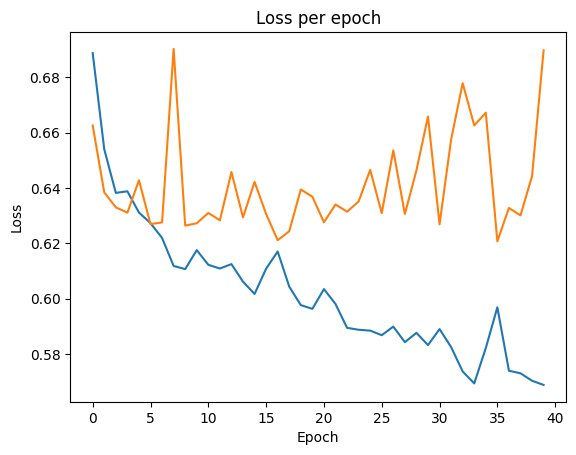

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

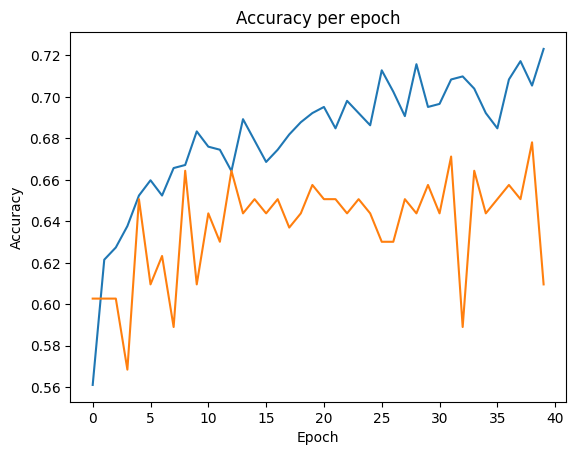

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### CNN with Attention

In [28]:
from keras.layers import Input, GlobalAveragePooling2D, Multiply, UpSampling2D
from keras.models import Model

def simple_attention(inputs):

    attention = Dense(inputs.shape[-1], activation='sigmoid')(inputs)
    
    attention = Multiply()([inputs, attention])
    
    return attention

# Input layer
inputs = Input(shape=(224, 224, 3), name='input_layer')

# Layer 1
layer1 = Conv2D(filters=128, kernel_size=3, activation=ELU(), padding="same")(inputs)
layer1 = BatchNormalization()(layer1)
layer1 = MaxPool2D()(layer1)

# Layer 2
layer2 = Conv2D(filters=128, kernel_size=3, activation=ELU(), padding="same")(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = MaxPool2D()(layer2)

# Layer 3
layer3 = Conv2D(filters=256, kernel_size=3, activation=ELU(), padding="same")(layer2)
layer3 = BatchNormalization()(layer3)
layer3 = MaxPool2D()(layer3)

layer3 = Conv2D(filters=512, kernel_size=3, activation=ELU(), padding="same",kernel_initializer='he_uniform')(layer3)
layer3 = BatchNormalization()(layer3)
layer3 = MaxPool2D()(layer3)

attention_layer = simple_attention(layer3)

drop = Dropout(rate=0.2)(attention_layer)

# Flatten and dense layers
flattened = GlobalAveragePooling2D()(attention_layer)

dense1 = Dense(1024, activation=ELU())(flattened)
dense1 = Dense(512, activation=ELU())(dense1)
dense1 = Dense(256, activation=ELU())(dense1)

outputs = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.5, patience=5, min_lr=0.00000001, verbose=1)

model.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_94"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_225 (Conv2D) │ (None, 224, 224,  │      3,584 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        512 │ conv2d_225[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_226 (Conv2D) │ (None, 112, 112,  │    147,584 │ max_pooling2d_24… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_226[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_227 (Conv2D) │ (None, 56, 56,    │    295,168 │ max_pooling2d_25… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_227[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_228 (Conv2D) │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_26… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      2,048 │ conv2d_228[0][0]  │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 14, 14,    │    262,656 │ max_pooling2d_27… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 14, 14,    │          0 │ max_pooling2d_27… │
│ (Multiply)          │ 512)              │            │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ multiply_2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1024)      │    525,312 │ global_average_p

 Total params: 3,074,945 (11.73 MB)

 Trainable params: 3,072,897 (11.72 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [29]:
# Training model
history = model.fit(x_train,y_train,batch_size=32,epochs=40,verbose=1,validation_data=(x_val,y_val),callbacks=[model_checkpoint])

Epoch 1/40


W0000 00:00:1717073646.145622    1771 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.5339 - loss: 1.0744

W0000 00:00:1717073661.564180    1773 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717073662.785158    1770 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.47945, saving model to att_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5361 - loss: 1.0652 - val_accuracy: 0.4795 - val_loss: 0.7398
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6391 - loss: 0.6637
Epoch 2: val_accuracy did not improve from 0.47945
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.6385 - loss: 0.6638 - val_accuracy: 0.4589 - val_loss: 0.7322
Epoch 3/40
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6870 - loss: 0.5793
Epoch 3: val_accuracy did not improve from 0.47945
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.6869 - loss: 0.5819 - val_accuracy: 0.4315 - val_loss: 0.8532
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6596 - loss: 0.6156
Epoch 4: val_accuracy did not improve from 0.47945
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.6595 - loss: 0.6157 - val_accuracy: 0.4521 - val_loss: 1.4650
Epoch 5/40
21/22 ━━━━━━━━━━━━━━━━━━━━

In [30]:
# testing model 

model2 = keras.models.load_model('att_model.keras', custom_objects={"ELU": keras.layers.ELU,"PReLU": keras.layers.PReLU}) # loading saved model

y_pred = model2.predict(x_test) # predicting

y_pred = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

W0000 00:00:1717073853.452408    1773 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step
Accuracy: 0.6917808219178082
Precision: 0.7261904761904762
Recall: 0.7349397590361446
F1 Score: 0.7305389221556886
Confusion Matrix:
[[40 23]
 [22 61]]


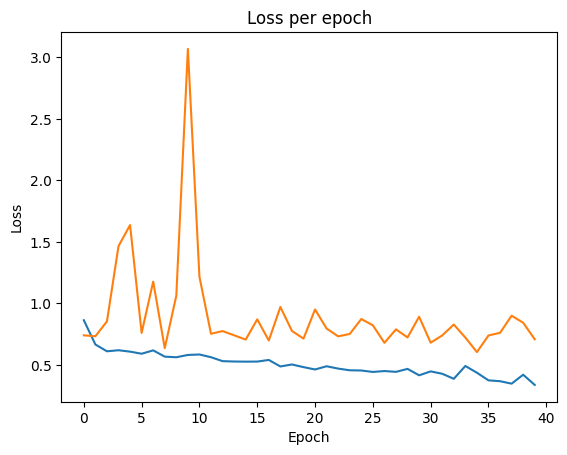

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

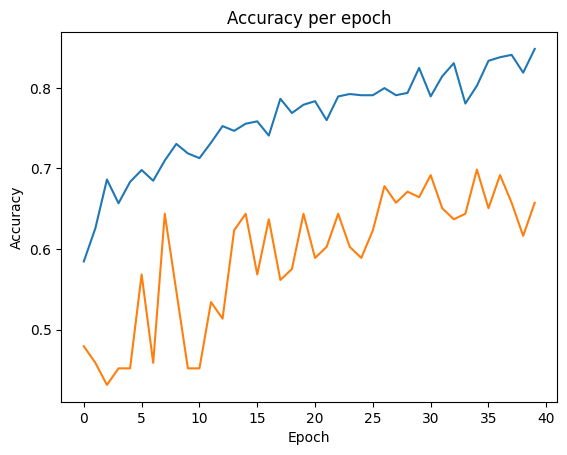

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### VGG16

In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the VGG16 model and create the feature extractor
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block5_pool').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary()

Model: "functional_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,025 (58.14 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5356 - loss: 0.7002
Epoch 1: val_accuracy improved from -inf to 0.69863, saving model to model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.5386 - loss: 0.6978 - val_accuracy: 0.6986 - val_loss: 0.6141 - learning_rate: 0.0010
Epoch 2/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7424 - loss: 0.5328
Epoch 2: val_accuracy improved from 0.69863 to 0.71918, saving model to model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.7439 - loss: 0.5309 - val_accuracy: 0.7192 - val_loss: 0.5798 - learning_rate: 0.0010
Epoch 3/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7879 - loss: 0.4763
Epoch 3: val_accuracy improved from 0.71918 to 0.74658, saving model to model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.7890 - loss: 0.4749 - val_accuracy: 0.7466 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8090

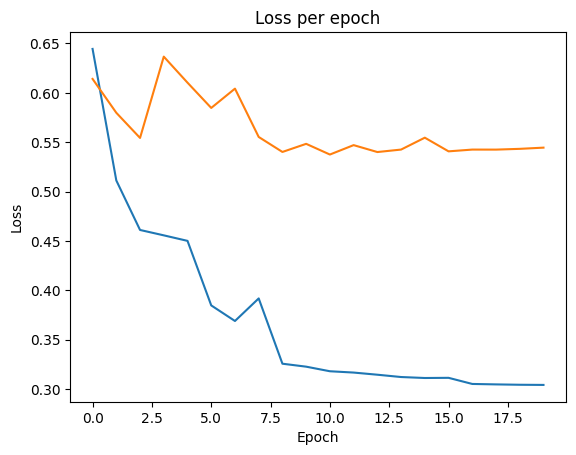

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

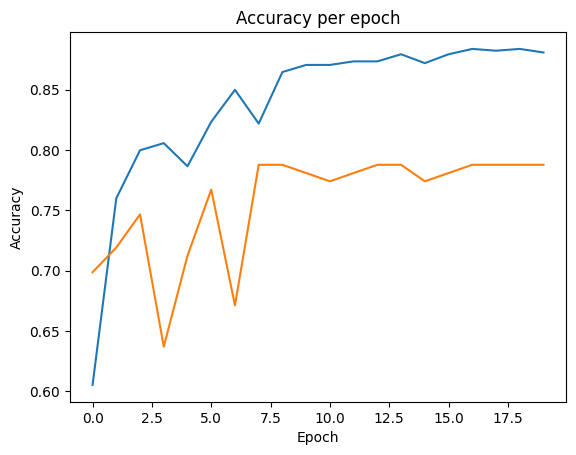

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Xception

In [41]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the Xception model and create the feature extractor
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=xception_model.input, outputs=xception_model.get_layer('block14_sepconv2_act').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_110"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_8[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_229 (Conv2D) │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_229[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 7:03 20s/step - accuracy: 0.5625 - loss: 0.6997

W0000 00:00:1717074066.850290    1771 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5749 - loss: 0.8486

W0000 00:00:1717074075.440797    1771 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717074078.665756    1770 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.71233, saving model to att_model.keras


W0000 00:00:1717074088.765485    1770 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5767 - loss: 0.8436 - val_accuracy: 0.7123 - val_loss: 0.5699 - learning_rate: 0.0010
Epoch 2/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8389 - loss: 0.4043
Epoch 2: val_accuracy improved from 0.71233 to 0.74658, saving model to att_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.8377 - loss: 0.4047 - val_accuracy: 0.7466 - val_loss: 0.5433 - learning_rate: 0.0010
Epoch 3/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8963 - loss: 0.2802
Epoch 3: val_accuracy improved from 0.74658 to 0.75342, saving model to att_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.8944 - loss: 0.2818 - val_accuracy: 0.7534 - val_loss: 0.5466 - learning_rate: 0.0010
Epoch 4/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9116 - loss: 0.2309
Epoch 4: val_accuracy did not improve from 0.75342
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9116 - loss: 0.2308 - val_accuracy: 0.7

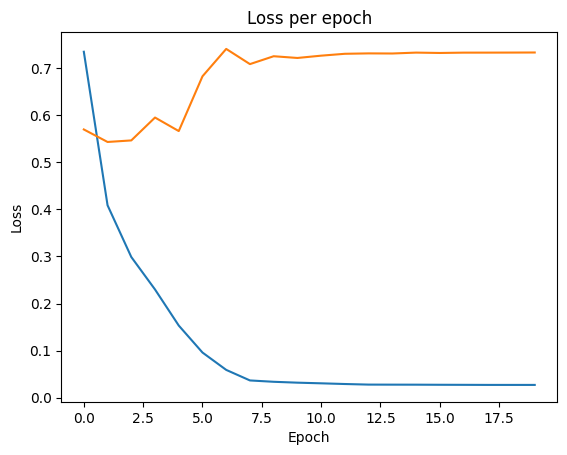

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

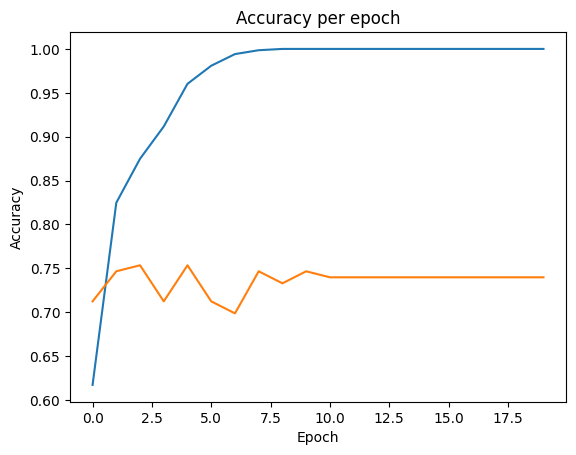

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### DenseNet121

In [45]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the DenseNet121 model and create the feature extractor
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=densenet_model.input, outputs=densenet_model.get_layer('relu').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_114"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_9[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,088,129 (30.85 MB)

 Trainable params: 1,050,625 (4.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 2/22 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5156 - loss: 0.8316  

W0000 00:00:1717074192.525421    1770 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.6141 - loss: 0.7596

W0000 00:00:1717074218.971629    1770 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.76027, saving model to att_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6166 - loss: 0.7554 - val_accuracy: 0.7603 - val_loss: 0.4916 - learning_rate: 0.0010
Epoch 2/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8266 - loss: 0.3617
Epoch 2: val_accuracy did not improve from 0.76027
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8274 - loss: 0.3602 - val_accuracy: 0.7192 - val_loss: 0.5042 - learning_rate: 0.0010
Epoch 3/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8882 - loss: 0.2771
Epoch 3: val_accuracy did not improve from 0.76027
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.8887 - loss: 0.2766 - val_accuracy: 0.7397 - val_loss: 0.5246 - learning_rate: 0.0010
Epoch 4/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9328 - loss: 0.1930
Epoch 4: val_accuracy did not improve from 0.76027
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9318 - loss: 0.1943 - val_accurac

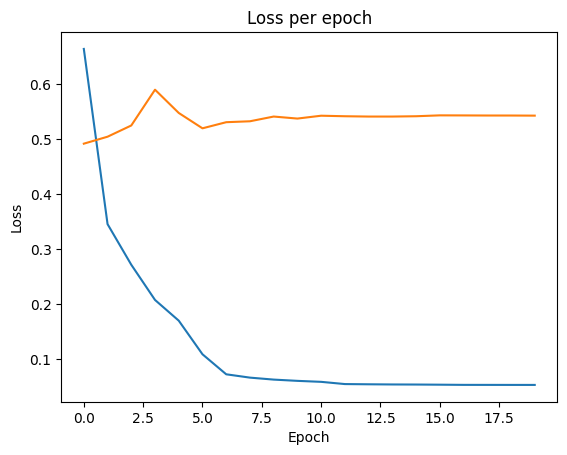

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

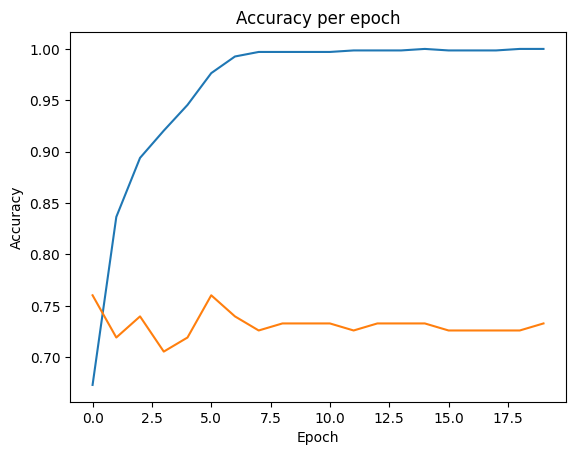

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### ResNet50

In [49]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the ResNet50 model and create the feature extractor
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer('conv5_block3_out').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_118"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [50]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 2/22 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5156 - loss: 0.9366 

W0000 00:00:1717074295.939478    1772 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5203 - loss: 0.9857

W0000 00:00:1717074303.006946    1773 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717074306.980565    1773 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.54110, saving model to att_model.keras


W0000 00:00:1717074313.186383    1770 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 857ms/step - accuracy: 0.5200 - loss: 0.9824 - val_accuracy: 0.5411 - val_loss: 0.7440 - learning_rate: 0.0010
Epoch 2/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5623 - loss: 0.6773
Epoch 2: val_accuracy did not improve from 0.54110
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5602 - loss: 0.6789 - val_accuracy: 0.5068 - val_loss: 0.6990 - learning_rate: 0.0010
Epoch 3/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5492 - loss: 0.6733
Epoch 3: val_accuracy improved from 0.54110 to 0.56849, saving model to att_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.5506 - loss: 0.6735 - val_accuracy: 0.5685 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 4/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5652 - loss: 0.6754
Epoch 4: val_accuracy improved from 0.56849 to 0.60959, saving model to att_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.5656 - loss: 0.6757 - val_accuracy: 0.6

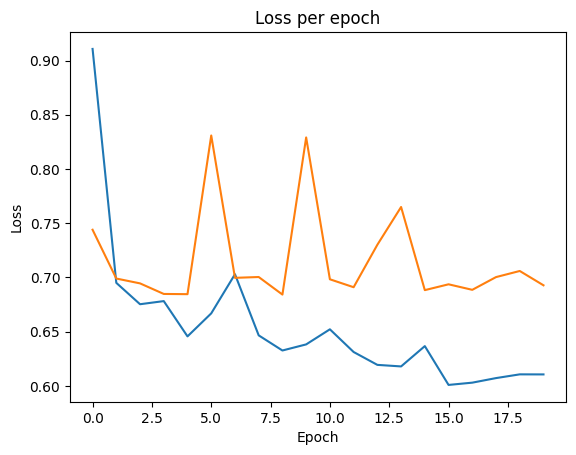

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

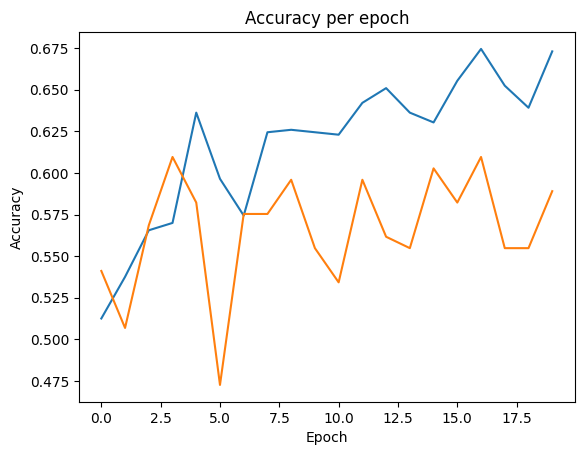

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Inception

In [53]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the InceptionV3 model and create the feature extractor
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.get_layer('mixed10').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

# Print the model summary
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_122"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_233 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_233[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_203      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_234 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_203[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_234[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_204      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_235 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_204[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_235[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_205      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 54, 54,    │          0 │ activation_205[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_236 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_28… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_236[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_206      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_237 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_206[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_237[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_207      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,901,985 (91.18 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [54]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 2/22 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6094 - loss: 1.4060 

W0000 00:00:1717074384.892579    1773 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.5671 - loss: 1.7147

W0000 00:00:1717074396.246876    1770 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717074402.269249    1772 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from 0.60959 to 0.73973, saving model to att_model.keras


W0000 00:00:1717074413.691523    1772 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5669 - loss: 1.7003 - val_accuracy: 0.7397 - val_loss: 0.5489 - learning_rate: 0.0010
Epoch 2/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7353 - loss: 0.5209
Epoch 2: val_accuracy did not improve from 0.73973
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.7363 - loss: 0.5207 - val_accuracy: 0.6986 - val_loss: 0.5436 - learning_rate: 0.0010
Epoch 3/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8250 - loss: 0.4400
Epoch 3: val_accuracy improved from 0.73973 to 0.75342, saving model to att_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8258 - loss: 0.4382 - val_accuracy: 0.7534 - val_loss: 0.4765 - learning_rate: 0.0010
Epoch 4/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8199 - loss: 0.3916
Epoch 4: val_accuracy improved from 0.75342 to 0.76712, saving model to att_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8210 - loss: 0.3903 - val_accuracy: 0.7671 

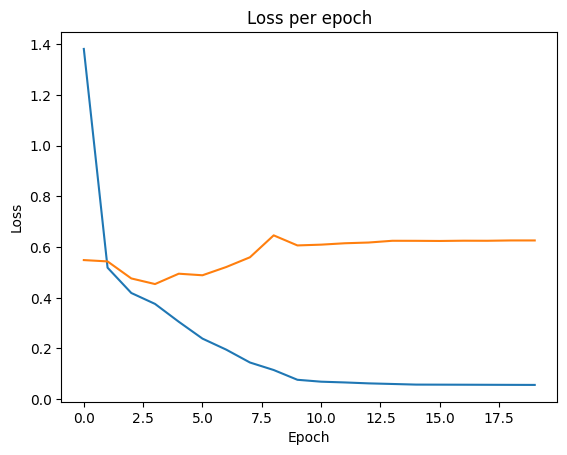

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

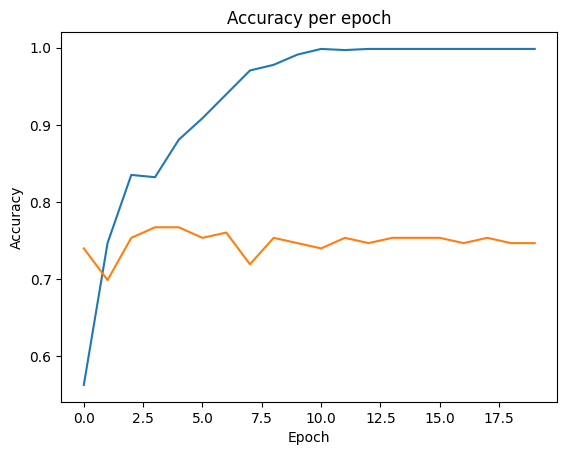

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Inception-ResNet-V2

In [57]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the InceptionResNetV2 model and create the feature extractor
inception_resnet_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_resnet_model.input, outputs=inception_resnet_model.get_layer('conv_7b_ac').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

Model: "functional_126"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_327 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_327[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_297      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_328 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_297[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_328[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_298      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_329 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_298[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_329[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_299      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 54, 54,    │          0 │ activation_299[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_330 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_32… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_330[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_300      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_331 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_300[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_331[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_301      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 55,911,649 (213.29 MB)

 Trainable params: 1,574,913 (6.01 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [58]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 11:27 33s/step - accuracy: 0.5625 - loss: 0.6966

W0000 00:00:1717074491.473581    1771 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.5433 - loss: 1.3934

W0000 00:00:1717074519.231847    1773 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.73973, saving model to att_model.keras


W0000 00:00:1717074530.841782    1773 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5451 - loss: 1.3793 - val_accuracy: 0.7397 - val_loss: 0.5297 - learning_rate: 0.0010
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7394 - loss: 0.5189
Epoch 2: val_accuracy improved from 0.73973 to 0.78082, saving model to att_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.7402 - loss: 0.5178 - val_accuracy: 0.7808 - val_loss: 0.4599 - learning_rate: 0.0010
Epoch 3/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8425 - loss: 0.4011
Epoch 3: val_accuracy did not improve from 0.78082
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.8416 - loss: 0.4006 - val_accuracy: 0.7808 - val_loss: 0.4460 - learning_rate: 0.0010
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8778 - loss: 0.3271
Epoch 4: val_accuracy did not improve from 0.78082
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.8769 - loss: 0.3280 - val_accuracy: 0.7329 - val_loss: 0.5899 - learning_rat

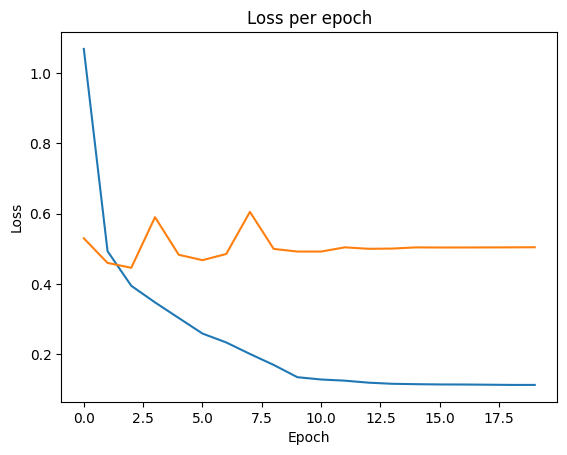

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

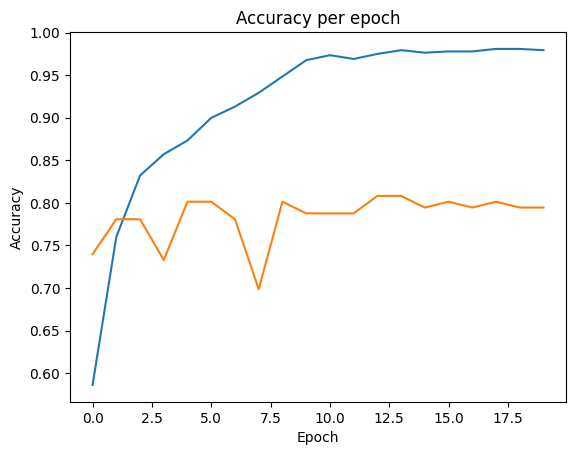

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()